### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 3 мая 2021, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 03 мая, -4 балла после 08:30 10 мая, -6 баллов после 08:30 17 мая, -8 баллов после 08:30 24 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In [2]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = None
        self.criterion = criterion
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __div_samples_rand(self, x, y, feature_id, threshold):#ok
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > x[:, feature_id].mean()
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y, all_probs):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        ind_srt = np.argsort(x)
        x_srt = x[ind_srt]
        y_srt = y[ind_srt]
        objl = np.where(y_srt[:-1] != y_srt[1:])[0] + 1
        obj2 = objl
        obj2[1:] = obj2[1:] - objl[:-1]
        dim_ob1 = objl.shape[0]
        data_l = np.zeros((self.num_classes, dim_ob1))
        data_l[y_srt[objl - 1], range(dim_ob1)] = 1
        data_l = (data_l*obj2).cumsum(axis=1)
        data_r = all_probs.reshape(-1, 1) - data_l
        objr = y.size - objl
        hold_l = data_l / objl
        hold_r = data_r / objr
        if self.criterion == 'misclass':
            temp_criterion = objl*(1 - np.max(hold_l, axis=0))
            temp_criterion += objr*(1 - np.max(hold_r, axis=0))
        elif self.criterion == 'gini':
            temp_criterion = objl*(1 - np.sum(hold_l**2, axis=0))
            temp_criterion += objr*(1 - np.sum(hold_r**2, axis=0))
        elif self.criterion == 'entropy':
            temp_criterion = (objl * (1 - np.sum(hold_l*np.log(abs(hold_l+1e-4)), axis=0)))
            temp_criterion += (objr * (1 - np.sum(hold_r*np.log(abs(hold_r+1e-4)), axis=0)))
        ind1 = np.argmax(temp_criterion)
        ind2 = objl[ind1]
        res1 = temp_criterion[ind1]
        res2 = (x_srt[ind2 - 1]+x_srt[ind2]) / 2
        return res1, res2

    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        all_probs = np.bincount(y, minlength=self.num_classes)
        most_often = np.argmax(all_probs)
        check1 = (y.shape[0] <= self.min_samples_split)
        check2 = (depth == self.max_depth)
        check3 = (all_probs[most_often]>=y.shape[0])
        if check1 or check2 or check3:
            tres = all_probs[most_often] / y.shape[0]
            self.tree[node_id] = (self.LEAF_TYPE, most_often, tres)
        else:
            best_tres = 0
            best_prop_ind = -1
            best_criterion = np.inf
            info = []
            for i in range(x.shape[1]):
                crit, th = self.__find_threshold(x[:, i], y, all_probs.flatten())
                if best_criterion > crit:
                    best_criterion = crit
                    best_prop_ind = i
                    best_tres = th
                    info.append((crit, i, th))
            info.sort()
            inf_len = len(info) - 1
            xl, xr, yl, yr = self.__div_samples(x, y, best_prop_ind, best_tres)
            if node_id < self.max_depth**2:
                while (xl.shape[0] == 0 or xr.shape[0] == 0):
                    inf_len -= 1
                    if inf_len < 0:
                        break
                    best_criterion = info[inf_len][0]
                    best_prop_ind = info[inf_len][1]
                    best_tres = info[inf_len][2]
                    xl, xr, yl, yr = self.__div_samples(x, y, best_prop_ind, best_tres)
            if (xl.shape[0] == 0 or xr.shape[0] == 0):
                self.tree[node_id] = (self.LEAF_TYPE, most_often, all_probs[most_often] / y.shape[0])
            else:
                self.tree[node_id] = (self.NON_LEAF_TYPE, best_prop_ind, best_tres)
                hold = all_probs.reshape(-1, 1) / y.shape[0]
                if self.criterion == 'misclass':
                    arg = y.shape[0]*(1 - np.max(hold, axis=0))
                    self.feature_importances_[best_prop_ind] += (arg - best_criterion) / self.amount
                elif self.criterion == 'gini':
                    arg = y.shape[0]*(1 - np.sum(hold**2, axis=0))
                    self.feature_importances_[best_prop_ind] += (arg - best_criterion) / self.amount
                elif self.criterion == 'entropy':
                    arg = y.shape[0]*(1 - np.sum(hold*np.log(abs(hold+1e-4)), axis=0))
                    self.feature_importances_[best_prop_ind] += (arg - best_criterion) / self.amount
                self.__fit_node(xl, yl, 2 * node_id + 1, depth + 1)
                self.__fit_node(xr, yr, 2 * node_id + 2, depth + 1)

    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.num_classes = np.unique(y).size
        self.amount = y.shape[0]
        self.feature_importances_ = np.zeros(x.shape[1])
        self.__fit_node(x, y, 0, 0)

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]

    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])

    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)

    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        l1 = len(self.feature_importances_)
        res = []
        for i in range(0, l1):
            res.append(tuple((self.feature_importances_[i], i)))
        return res


In [3]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [4]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [5]:
%time clf.fit(X_train, y_train)

Wall time: 1.5 ms


DecisionTreeClassifier()

In [6]:
%time my_clf.fit(X_train, y_train)

Wall time: 13 ms


In [7]:
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.9444444444444444
0.9444444444444444


## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [8]:
%time clf.fit(X_train, y_train)

Wall time: 2.01 ms


DecisionTreeClassifier()

In [9]:
%time my_clf.fit(X_train, y_train)

Wall time: 9 ms


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


In [10]:
df = pd.read_csv('Speed Dating Data.csv', encoding='latin1')

In [11]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

In [12]:
df = df.iloc[:, :97]
df = df.drop(['id'], axis=1)
df = df.drop(['idg'], axis=1)
df = df.drop(['condtn'], axis=1)
df = df.drop(['round'], axis=1)
df = df.drop(['order'], axis=1)
df = df.drop(['partner'], axis=1)
df = df.drop(['position', 'positin1'], axis=1)
df = df.drop(['undergra'], axis=1)
df = df.drop(['expnum'], axis=1)
df.shape

(8378, 87)

In [13]:
words = ['age_o', 'race_o', 'pf_o_att', 
              'pf_o_sin', 'pf_o_int',
              'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
              'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o',
              'amb_o', 'shar_o', 'like_o', 'prob_o','met_o']
for word in words:
    df[word] = df[word].fillna(df[word].mode()[0])

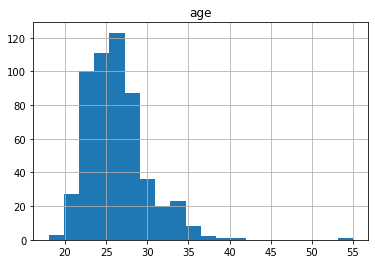

In [14]:
plt.figure()
plt.title('age')
df.drop_duplicates(subset=['iid']).age.hist(bins=20)
plt.show()

In [15]:
df['age'] = df['age'].fillna(df.age.mean())

In [16]:
for i, group in df.groupby('field_cd'):
    print('=' * 10)
    print('Field Code {}'.format(i))
    print(group.field.unique())

Field Code 1.0
['Law' 'law' 'LAW' 'Law and Social Work'
 'Law and English Literature (J.D./Ph.D.)' 'Intellectual Property Law'
 'Law/Business']
Field Code 2.0
['Economics' 'Mathematics' 'Statistics' 'math' 'Mathematics, PhD' 'Stats'
 'math of finance' 'Math']
Field Code 3.0
['Psychology' 'Speech Language Pathology' 'Speech Languahe Pathology'
 'Educational Psychology' 'Organizational Psychology' 'psychology'
 'Communications' 'Sociology' 'psychology and english' 'theory'
 'Health policy' 'Clinical Psychology' 'Sociology and Education'
 'sociology' 'Anthropology/Education' 'speech pathology'
 'Speech Pathology' 'Anthropology' 'School Psychology' 'anthropology'
 'Counseling Psychology' 'African-American Studies/History']
Field Code 4.0
['Medicine' 'Art History/medicine'
 'Sociomedical Sciences- School of Public Health' 'Epidemiology'
 'GS Postbacc PreMed' 'medicine']
Field Code 5.0
['Operations Research' 'Mechanical Engineering' 'Engineering'
 'Electrical Engineering' 'Operations Researc

In [17]:
df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)
df = df.drop(['field'], axis=1)
encoder = OneHotEncoder()
dat = encoder.fit_transform(df['field_cd'].values.reshape(-1,1))
dat = dat.toarray().T
for i in range(dat.shape[0]):
    df['field_'+str(i+1)] = dat[i]

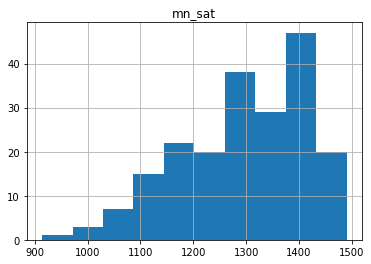

In [18]:
df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].str.replace(',', '').astype(np.float)
plt.figure()
plt.title('mn_sat')
df.drop_duplicates('iid').mn_sat.hist()
plt.show()
mean_temp = df.drop_duplicates('iid').mn_sat.mean()
df['mn_sat'] = df['mn_sat'].fillna(mean_temp)

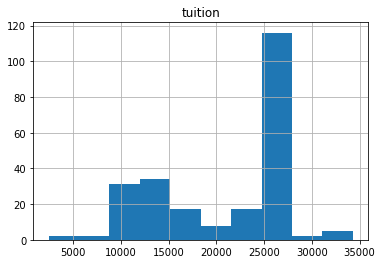

In [19]:
df.loc[:, 'tuition'] = df.loc[:, 'tuition'].str.replace(',', '').astype(np.float)
plt.figure()
plt.title('tuition')
df.drop_duplicates('iid').tuition.hist()
plt.show()
mean_temp = df.drop_duplicates('iid').tuition.mean()
df['tuition'] = df['tuition'].fillna(mean_temp)

In [20]:
df['race'] = df['race'].fillna(-1)
encoder = OneHotEncoder()
dat = encoder.fit_transform(df['race'].values.reshape(-1,1))
dat = dat.toarray().T
for i in range(dat.shape[0]):
    df['race_'+str(i+1)] = dat[i]
df = df.drop(['race'], axis=1)
df = df.drop(['field_cd'], axis=1)

In [21]:
df.imprace = df['imprace'].fillna(df['imprace'].mean())
df.imprelig = df['imprelig'].fillna(df['imprelig'].mean())
df = df.drop(['from', 'zipcode'], axis=1)

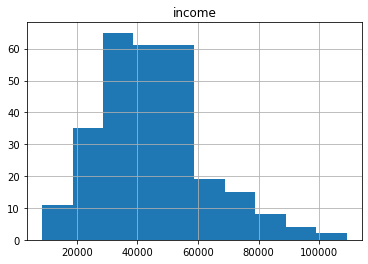

In [22]:
df.loc[:, 'income'] = df.loc[:, 'income'].str.replace(',', '').astype(np.float)
plt.figure()
plt.title('income')
df.drop_duplicates('iid').loc[:, 'income'].hist()
plt.show()
mean_temp = df.drop_duplicates('iid').income.mean()
df['income'] = df['income'].fillna(mean_temp)

In [23]:
words = ['date', 'goal', 'go_out']
for word in words:
    df[word] =df[word].fillna(-1)
    encoder = OneHotEncoder()
    dat = encoder.fit_transform(df[word].values.reshape(-1,1))
    dat = dat.toarray().T
    for i in range(dat.shape[0]):
        df[word+'_'+str(i+1)] = dat[i]
df = df.drop(words, axis=1)

In [24]:
words = ['sports','tvsports','exercise','dining','museums','art','hiking','gaming',
         'clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga']
for word in words:
    df[word] = df[word].fillna(df[word].mode()[0])

In [25]:
feat = ['iid', 'wave', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']
temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)
idx = ((temp.wave < 6) | (temp.wave > 9)) & (temp.totalsum < 99)
idx = ((temp.wave >= 6) & (temp.wave <= 9))
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].sum(axis=1)
df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] = \
(df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100

In [26]:
feat = ['iid', 'wave', 'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']
temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)
idx = ((temp.wave < 6) | (temp.wave > 9)) & (temp.totalsum < 90) & (temp.totalsum != 0)
idx = ((temp.wave >= 6) & (temp.wave <= 9))
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].sum(axis=1)
df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] = \
(df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100
df = df.drop(['temp_totalsum'], axis=1)

In [27]:
for i in [4, 5]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
            'intel{}_1'.format(i), 'fun{}_1'.format(i), 
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]
    
    if i != 4:
        feat.remove('shar{}_1'.format(i))
    
    df = df.drop(feat, axis=1)

In [28]:
for i, group in df.groupby('career_c'):
    print('=' * 10)
    print('Career Code {}'.format(i))
    print(group.career.unique())
df.career_c.isnull().sum()
df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)
df = df.drop(['career'], axis=1)

Career Code 1.0
['lawyer/policy work' 'lawyer' 'Law' 'Corporate Lawyer' 'Lawyer'
 'Corporate attorney' 'law' 'Intellectual Property Attorney' 'LAWYER'
 'attorney' 'Lawyer or professional surfer' 'lawyer/gov.position'
 'Law or finance' 'IP Law' 'Academic (Law)' 'Private Equity' 'attorney?'
 'Corporate law' 'tax lawyer' 'Business/Law' 'Assistant District Attorney']
Career Code 2.0
['Academia, Research, Banking, Life' 'academics or journalism' 'Professor'
 'Academic' 'academia' 'teacher' 'industrial scientist'
 'teaching and then...' 'Professor of Media Studies'
 'Education Administration' 'Academic or Research staff'
 'University Professor' 'Research Scientist'
 'research in industry or academia' 'Teacher/Professor'
 'no idea, maybe a professor' 'a research position' 'professor' 'teaching'
 'engineering professional' 'research' 'Neuroscientist/Professor'
 'Education' 'Professor and Government Official'
 'physicist, probably academia' 'college art teacher' 'academic'
 'Research scientist,

In [29]:
encoder = OneHotEncoder()
dat = encoder.fit_transform(df['career_c'].values.reshape(-1,1))
dat = dat.toarray().T
for i in range(dat.shape[0]):
    df['career_c'+'_'+str(i+1)] = dat[i]
df = df.drop(['career_c'], axis=1)
df = df.drop(['wave'], axis=1)

In [30]:
df

,iid,gender,pid,match,int_corr,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o,age,mn_sat,tuition,imprace,imprelig,income,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,attr1_1,sinc1_1,...,field_17,field_18,field_19,race_1,race_2,race_3,race_4,race_5,race_6,date_1,date_2,date_3,date_4,date_5,date_6,date_7,date_8,goal_1,goal_2,goal_3,goal_4,goal_5,goal_6,goal_7,go_out_1,go_out_2,go_out_3,go_out_4,go_out_5,go_out_6,go_out_7,go_out_8,career_c_1,career_c_2,career_c_3,career_c_4,career_c_5,career_c_6,career_c_7,career_c_8,career_c_9,career_c_10,career_c_11,career_c_12,career_c_13,career_c_14,career_c_15,career_c_16,career_c_17,career_c_18
0,1,0,11.0,0,0.14,0,27.0,2.0,35.0,20.0,20.0,20.0,0.0,5.0,0,6.0,8.0,8.0,8.0,8.0,6.0,7.0,4.0,2.0,21.0,1295.99505,21036.128205,2.0,4.0,69487.000000,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,15.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,0,12.0,0,0.54,0,22.0,2.0,60.0,0.0,0.0,40.0,0.0,0.0,0,7.0,8.0,10.0,7.0,7.0,5.0,8.0,4.0,2.0,21.0,1295.99505,21036.128205,2.0,4.0,69487.000000,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,15.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1,0,13.0,1,0.16,1,22.0,4.0,19.0,18.0,19.0,18.0,14.0,12.0,1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,1.0,21.0,1295.99505,21036.128205,2.0,4.0,69487.000000,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,15.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,0,14.0,1,0.61,0,23.0,2.0,30.0,5.0,15.0,40.0,5.0,5.0,1,7.0,8.0,9.0,8.0,9.0,8.0,7.0,7.0,2.0,21.0,1295.99505,21036.128205,2.0,4.0,69487.000000,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,15.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1,0,15.0,1,0.21,0,24.0,3.0,30.0,10.0,20.0,10.0,10.0,20.0,1,8.0,7.0,9.0,6.0,9.0,7.0,8.0,6.0,2.0,21.0,1295.99505,21036.128205,2.0,4.0,69487.000000,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,15.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,552,1,526.0,0,0.64,0,26.0,3.0,10.0,10.0,30.0,20.0,10.0,15.0,1,10.0,5.0,3.0,2.0,6.0,5.0,6.0,1.0,2.0,25.0,1295.99505,21036.128205,1.0,1.0,45285.637011,8.0,2.0,5.0,10.0,10.0,10.0,7.0,1.0,9.0,8.0,3.0,7.0,9.0,10.0,10.0,7.0,3.0,10.0,70.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8374,552,1,527.0,0,0.71,0,24.0,6.0,50.0,20.0,10.0,5.0,10.0,5.0,0,6.0,3.0,7.0,3.0,7.0,2.0,2.0,2.0,2.0,25.0,1295.99505,21036.128205,1.0,1.0,45285.637011,

In [31]:
df_male = df.query('gender == 1').drop_duplicates(subset=['iid', 'pid'])\
                                 .drop(['gender'], axis=1)\
                                 .dropna()
df_female = df.query('gender == 0').drop_duplicates(subset=['iid'])\
                                   .drop(['gender', 'match', 'int_corr', 'samerace'], axis=1)\
                                   .dropna()
        
df_female.columns = df_female.columns + '_f'

In [32]:
df_female = df_female.drop(['pid_f'], axis=1)
df_pair = df_male.join(df_female.set_index('iid_f'), on='pid', how='inner')
df_pair = df_pair.drop(['iid', 'pid'], axis=1)

In [33]:
df_pair

,match,int_corr,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o,age,mn_sat,tuition,imprace,imprelig,income,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,...,field_17_f,field_18_f,field_19_f,race_1_f,race_2_f,race_3_f,race_4_f,race_5_f,race_6_f,date_1_f,date_2_f,date_3_f,date_4_f,date_5_f,date_6_f,date_7_f,date_8_f,goal_1_f,goal_2_f,goal_3_f,goal_4_f,goal_5_f,goal_6_f,goal_7_f,go_out_1_f,go_out_2_f,go_out_3_f,go_out_4_f,go_out_5_f,go_out_6_f,go_out_7_f,go_out_8_f,career_c_1_f,career_c_2_f,career_c_3_f,career_c_4_f,career_c_5_f,career_c_6_f,career_c_7_f,career_c_8_f,career_c_9_f,career_c_10_f,career_c_11_f,career_c_12_f,career_c_13_f,career_c_14_f,career_c_15_f,career_c_16_f,career_c_17_f,career_c_18_f
100,0,0.14,0,21.0,4.0,15.0,20.0,20.0,15.0,15.0,15.0,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0,2.0,27.0,1295.99505,21036.128205,7.0,3.0,45285.637011,8.0,7.0,2.0,6.0,7.0,5.0,5.0,5.0,4.0,9.0,2.0,4.0,8.0,7.0,8.0,5.0,1.0,7.0,35.0,20.0,20.0,20.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
110,0,0.54,0,21.0,4.0,15.0,20.0,20.0,15.0,15.0,15.0,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0,1.0,22.0,1295.99505,21036.128205,1.0,1.0,29237.000000,9.0,7.0,9.0,8.0,7.0,6.0,3.0,3.0,5.0,6.0,6.0,4.0,7.0,7.0,9.0,5.0,5.0,7.0,60.0,0.0,0.0,40.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
120,1,0.16,1,21.0,4.0,15.0,20.0,20.0,15.0,15.0,15.0,1,5.0,8.0,9.0,8.0,5.0,7.0,7.0,5.0,1.0,22.0,1295.99505,21036.128205,3.0,5.0,45285.637011,7.0,8.0,2.0,9.0,5.0,6.0,4.0,7.0,7.0,6.0,8.0,10.0,8.0,9.0,9.0,8.0,1.0,3.0,19.0,18.0,19.0,18.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
130,1,0.61,0,21.0,4.0,15.0,20.0,20.0,15.0,15.0,15.0,1,7.0,6.0,8.0,7.0,6.0,8.0,7.0,6.0,2.0,23.0,1295.99505,21036.128205,1.0,1.0,56580.000000,10.0,6.0,8.0,8.0,3.0,3.0,10.0,8.0,8.0,6.0,7.0,3.0,10.0,6.0,8.0,6.0,1.0,8.0,30.0,5.0,15.0,40.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
140,1,0.21,0,21.0,4.0,15.0,20.0,20.0,15.0,15.0,15.0,1,5.0,6.0,7.0,7.0,6.0,6.0,6.0,6.0,2.0,24.0,1295.99505,21036.128205,3.0,1.0,36782.000000,9.0,7.0,9.0,7.0,4.0,3.0,6.0,7.0,9.0,8.0,6.0,9.0,9.0,6.0,7.0,2.0,1.0,5.0,30.0,10.0,20.0,10.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8289,0,0.23,0,22.0,4.0,20.0,20.0,10.0,15.0,5.0,30.0,0,7.0,7.0,8.0,6.0,7.0,5.0,7.0,5.0,2.0,30.0,1295.99505,21036.128205,8.0,8.0,45285.637011,10.0,8.0,4.0,10.0,3.0,2.0,2.0,5.0,1.0,9.0,6.0,4.0,6.0,7.0,10.0,4.0,1.0,7.0,40.0,10.0,20.0,10.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8311,0,0.29,0,22.

In [34]:
X = df_pair.drop(['match'], axis=1)
X = X.values
y = df_pair['match'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [35]:
my_model = MyDecisionTreeClassifier(max_depth=21, criterion = 'gini')

In [36]:
my_model.fit(X_train, y_train)

In [37]:
print("My model test score: ", accuracy_score(my_model.predict(X_test), y_test))

My model test score:  0.8395522388059702


Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий информативности. Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. Какой максимальной точности удалось достигнуть?

In [38]:
criterion1 = ['misclass', 'gini', 'entropy']
dep = [5*i for i in range(1,12)]
splt = [2*i for i in range(2,8)]
from copy import deepcopy as dp

In [39]:
data = np.zeros((len(splt),len(dep)))
ans = dict()
for crit in criterion1:
    ans[crit] = dp(data)
dataf = np.zeros((len(splt),len(dep)))
ansf = dict()
for crit in criterion1:
    ansf[crit] = dp(dataf)

In [40]:
best_score = 0
best_crit = -1
best_split = -1
best_depth = -1
best_scoref = 0
best_critf = -1
best_splitf = -1
best_depthf = -1
amount = len(criterion1)*len(splt)*len(dep)
i = -1
j = -1
skf1 = KFold(n_splits=3)
for crit in criterion1:
    i = -1
    for splth in splt:
        i+=1
        j=-1
        for dpth in dep:
            j+=1
            res = 0
            res1 = 0
            for train, test in skf1.split(X, y):
                my_model = MyDecisionTreeClassifier(min_samples_split =splth, max_depth=dpth, criterion = crit)
                my_model.fit(X[train], y[train])
                hold = accuracy_score(my_model.predict(X[test]), y[test])
                hold1 = f1_score(my_model.predict(X[test]), y[test], average='macro')
                res = res + hold
                res1 = res1 + hold1
            res = res/3
            res1 = res1/3
            ans[crit][i][j] = res
            ansf[crit][i][j] = res1
            amount-=1
            print(" accuracy: ",res, " f1score: ", res1, "remains_calc: ", amount)
            if res > best_score:
                best_score = res
                best_crit = crit
                best_split = splth
                best_depth = dpth
            if res1 > best_scoref:
                best_scoref = res1
                best_critf = crit
                best_splitf = splth
                best_depthf = dpth

 accuracy:  0.8371919342793129  f1score:  0.5285556891258935 remains_calc:  197
 accuracy:  0.830470500373413  f1score:  0.6155313177215912 remains_calc:  196
 accuracy:  0.8242469504605427  f1score:  0.6163030628153792 remains_calc:  195
 accuracy:  0.8157829225790391  f1score:  0.6356151620271017 remains_calc:  194
 accuracy:  0.8200149365197907  f1score:  0.6351264451657713 remains_calc:  193
 accuracy:  0.8195170525267613  f1score:  0.6347235652293716 remains_calc:  192
 accuracy:  0.8195170525267613  f1score:  0.6347235652293716 remains_calc:  191
 accuracy:  0.8195170525267613  f1score:  0.6347235652293716 remains_calc:  190
 accuracy:  0.8195170525267613  f1score:  0.6347235652293716 remains_calc:  189
 accuracy:  0.8195170525267613  f1score:  0.6347235652293716 remains_calc:  188
 accuracy:  0.8195170525267613  f1score:  0.6347235652293716 remains_calc:  187
 accuracy:  0.8364451082897685  f1score:  0.5279916296869683 remains_calc:  186
 accuracy:  0.8297236743838686  f1score: 

 accuracy:  0.8289768483943241  f1score:  0.6740204793195227 remains_calc:  94
 accuracy:  0.8279810804082648  f1score:  0.6690608528192632 remains_calc:  93
 accuracy:  0.8269853124222055  f1score:  0.6652408336542416 remains_calc:  92
 accuracy:  0.8269853124222055  f1score:  0.6652408336542416 remains_calc:  91
 accuracy:  0.8269853124222055  f1score:  0.6652408336542416 remains_calc:  90
 accuracy:  0.8269853124222055  f1score:  0.6652408336542416 remains_calc:  89
 accuracy:  0.8269853124222055  f1score:  0.6652408336542416 remains_calc:  88
 accuracy:  0.838436644261887  f1score:  0.4967411289891717 remains_calc:  87
 accuracy:  0.8254916604431167  f1score:  0.6071442838651939 remains_calc:  86
 accuracy:  0.829225790390839  f1score:  0.6376868313760741 remains_calc:  85
 accuracy:  0.8212596465023649  f1score:  0.6694293305110524 remains_calc:  84
 accuracy:  0.8267363704256908  f1score:  0.6705370946854226 remains_calc:  83
 accuracy:  0.8259895444361464  f1score:  0.6660117896

Лучшие результаты:

In [41]:
print("best params for accuracy: ")
print("best_score: ",best_score)
print("best_crit: ", best_crit)
print("min_samples_split: ", best_split)
print("best_depth: ", best_depth)

best params for accuracy: 
best_score:  0.8399302962409759
best_crit:  entropy
min_samples_split:  12
best_depth:  5


In [42]:
print("best params for f1score: ")
print("best_fscore: ",best_scoref)
print("best_crit: ", best_critf)
print("min_samples_split: ", best_splitf)
print("best_depth: ", best_depthf)

best params for f1score: 
best_fscore:  0.6819040099368632
best_crit:  gini
min_samples_split:  14
best_depth:  25


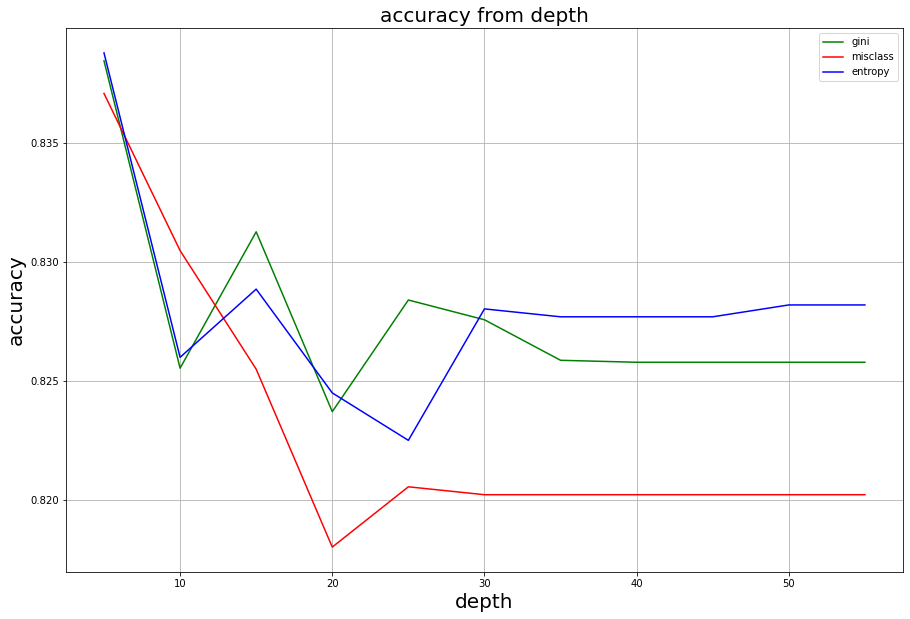

In [43]:
plt.figure(figsize = (15,10))
plt.grid()
plt.title("accuracy from depth", fontsize =20)
plt.xlabel("depth", fontsize =20)
plt.ylabel("accuracy", fontsize =20)
plt.plot(dep, ans["gini"].mean(axis=0), color = 'green', label = 'gini')
plt.plot(dep, ans["misclass"].mean(axis=0), color = 'red', label = 'misclass')
plt.plot(dep, ans["entropy"].mean(axis=0), color = 'blue', label = 'entropy')
plt.legend()
plt.show()

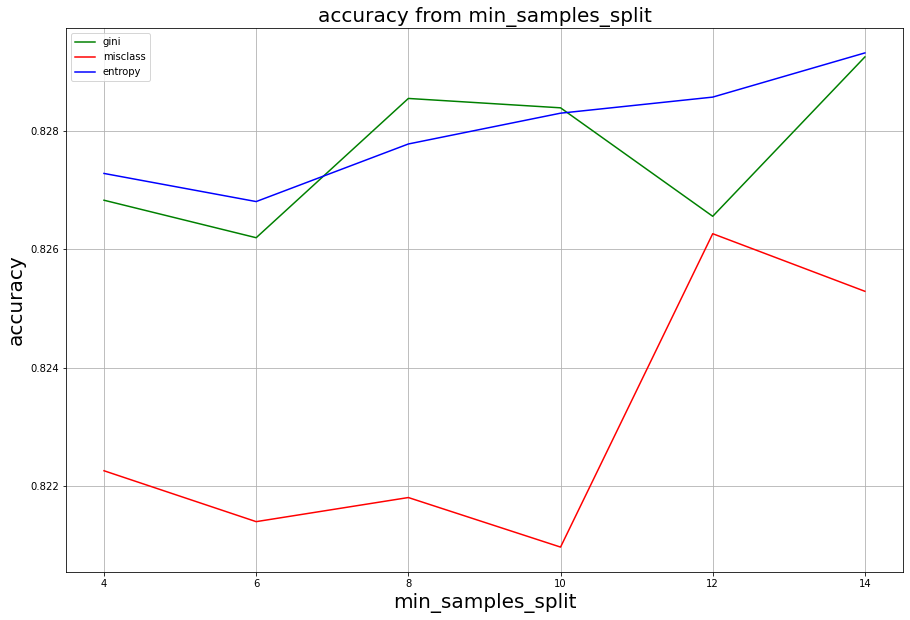

In [44]:
plt.figure(figsize = (15,10))
plt.grid()
plt.title("accuracy from min_samples_split", fontsize =20)
plt.xlabel("min_samples_split", fontsize =20)
plt.ylabel("accuracy", fontsize =20)
plt.plot(splt, ans["gini"].mean(axis=1), color = 'green', label = 'gini')
plt.plot(splt, ans["misclass"].mean(axis=1), color = 'red', label = 'misclass')
plt.plot(splt, ans["entropy"].mean(axis=1), color = 'blue', label = 'entropy')
plt.legend()
plt.show()

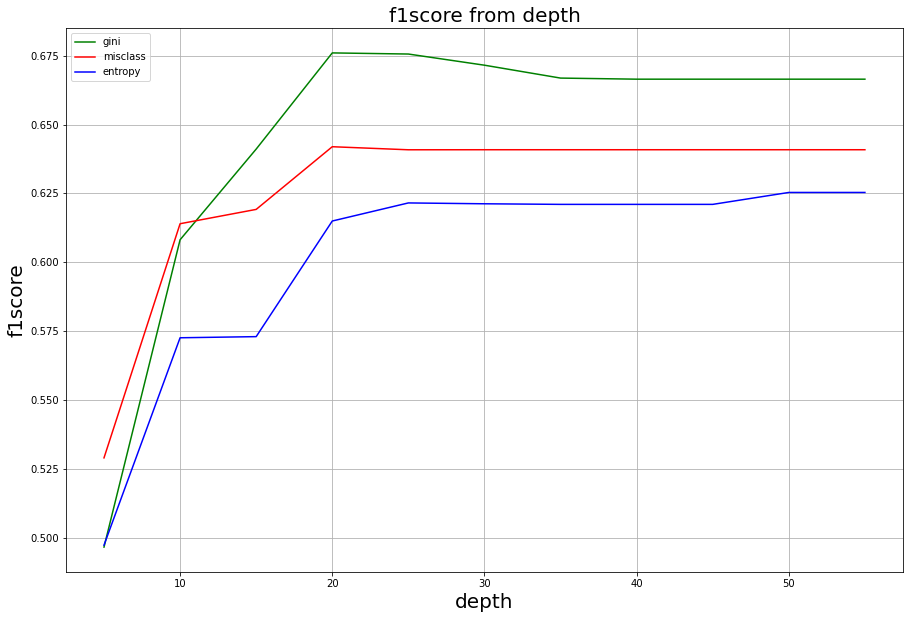

In [45]:
plt.figure(figsize = (15,10))
plt.grid()
plt.title("f1score from depth", fontsize =20)
plt.xlabel("depth", fontsize =20)
plt.ylabel("f1score", fontsize =20)
plt.plot(dep, ansf["gini"].mean(axis=0), color = 'green', label = 'gini')
plt.plot(dep, ansf["misclass"].mean(axis=0), color = 'red', label = 'misclass')
plt.plot(dep, ansf["entropy"].mean(axis=0), color = 'blue', label = 'entropy')
plt.legend()
plt.show()

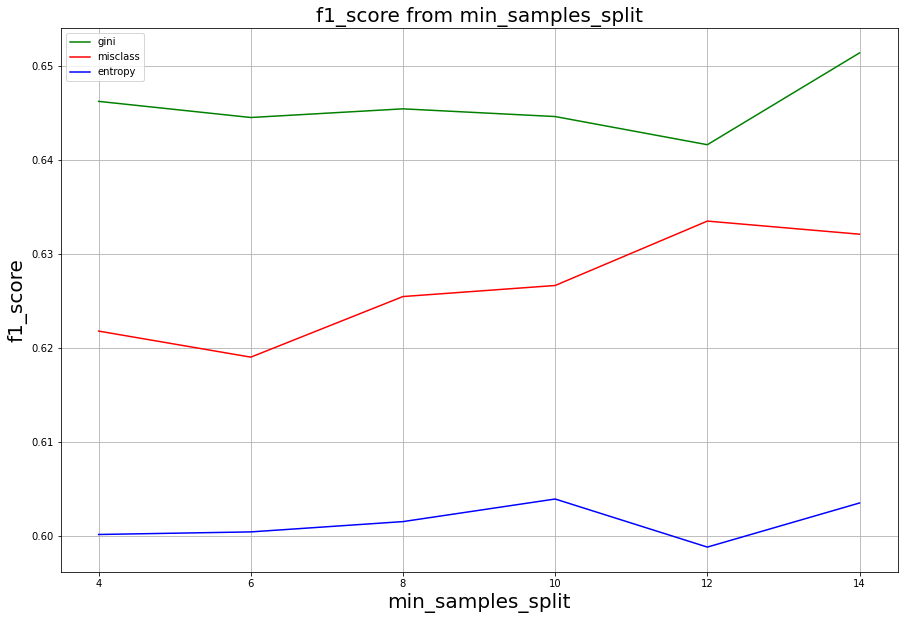

In [46]:
plt.figure(figsize = (15,10))
plt.grid()
plt.title("f1_score from min_samples_split", fontsize =20)
plt.xlabel("min_samples_split", fontsize =20)
plt.ylabel("f1_score", fontsize =20)
plt.plot(splt, ansf["gini"].mean(axis=1), color = 'green', label = 'gini')
plt.plot(splt, ansf["misclass"].mean(axis=1), color = 'red', label = 'misclass')
plt.plot(splt, ansf["entropy"].mean(axis=1), color = 'blue', label = 'entropy')
plt.legend()
plt.show()

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [47]:
X1 = df_pair.drop(['match'], axis=1)
X1.columns

Index(['int_corr', 'samerace', 'age_o', 'race_o', 'pf_o_att', 'pf_o_sin',
       'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
       ...
       'career_c_9_f', 'career_c_10_f', 'career_c_11_f', 'career_c_12_f',
       'career_c_13_f', 'career_c_14_f', 'career_c_15_f', 'career_c_16_f',
       'career_c_17_f', 'career_c_18_f'],
      dtype='object', length=252)

In [48]:
my_model = MyDecisionTreeClassifier(min_samples_split = 14, max_depth=25, criterion = 'gini')
my_model.fit(X, y)

In [49]:
a = my_model.get_feature_importance()

In [50]:
a =sorted(a)

In [51]:
print("feature top:")
print("------------")
for elem in a[-1:-10:-1]:
    print(X1.columns[elem[1]])

feature top:
------------
dec_o
prob_o
pf_o_att
goal_7_f
pf_o_fun_f
race_6
date_7
attr3_1_f
reading


## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

